   
# Creating new Emojis with a GAN

# The dataset

The dataset consists of 666 smiley emojis in different brand styles (apple, facebook, google, joypixels, Samsung, twitter and Windows). 
It was derived from the kaggle dataset: https://www.kaggle.com/datasets/subinium/emojiimage-dataset. 
Only the smiley emojis were taken into account. For each image the transparency (alpha channel) was removed and a white background added.

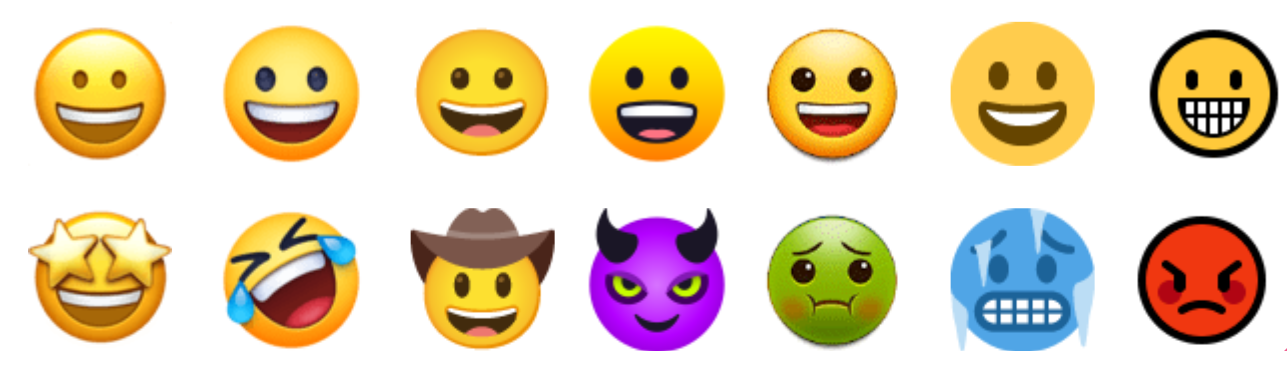

# Setup

## Import Libraries

In [ ]:
import os
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T
from torchvision import datasets
from google.colab import drive
from torchvision.transforms.transforms import Resize


## Mount Google Drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the directory that contains the data.

## Path to base directory in google drive:
base_dir = "/content/drive/My Drive/MachineLearning/GAN/data/Emojis"
image_dir = os.path.join(base_dir, "images")

## Define Parameters

Here I set some of the later model parameters.

In [ ]:
## Attributes of the images
number_of_channels = 3
resizeTo = 23

## Output Folder
name_outputfolder = "model07" 

In [ ]:
## Transformation of the images (resized and normalized)
transform = transforms.Compose([                           
    transforms.Resize((resizeTo,resizeTo)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

In [ ]:
## Model-Parameters
batch_size = 64
n_epochs = 2000
z_dim = 64
display_step = 500

lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 5
device = 'cuda'

## Define Functions

Here I define some helper functions. 
For example a function that shows and saves the generated images to the predefined output folder

In [ ]:
def show_tensor_images(image_tensor, num_images=4, size=(number_of_channels, resizeTo, resizeTo), outputdir = "00", filename = "00", prnt = False):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=2)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    fig1 = plt.gcf()
    plt.show()
    
    if prnt :
        output_dir = os.path.join("/content/drive/My Drive/MachineLearning/GAN/Output/", outputdir )
        if not os.path.exists(output_dir):
          os.mkdir(output_dir)

        file_path = os.path.join(output_dir, filename)
        fig1.savefig(file_path)

def make_grad_hook():
    '''
    Function to keep track of gradients for visualization purposes, 
    which fills the grads list when using model.apply(grad_hook).
    '''
    grads = []
    def grad_hook(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            grads.append(m.weight.grad)
    return grads, grad_hook

## Show Dataset

In this section I inspect the dataset and the transformation of the images.

In [ ]:
## Create list with the file names
pic_lst = os.listdir(image_dir)
print("Number of emojis:", len(pic_lst))

Number of emojis: 666


In [ ]:
## Chose a random image
image_path = os.path.join(image_dir, pic_lst[24])
print(image_path)

/content/drive/My Drive/MachineLearning/GAN/data/Emojis/images/Samsung (3).png


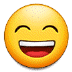

In [ ]:
# Read the image
image = Image.open(image_path).convert('RGB')
image

In [ ]:

# Convert the image to PyTorch tensor
tensor = transform(image)

# print the converted image tensor
print(tensor)

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])


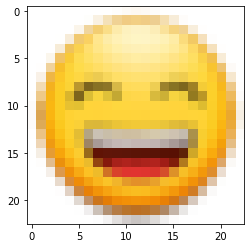

In [ ]:
show_tensor_images(tensor, prnt = True)

## Create the dataset and dataloader

Now I need to create a dataset out of my image folder. 

In [ ]:
## Define a custom loader (this was needed when the images had a fourth alpha channel, which I later manually removed)
def pil_loader_rgba(path: str) -> Image.Image:
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')  # RGBA would force an alpha channel

In [ ]:
## Create the dataset
data = datasets.ImageFolder(root = base_dir, transform = transform, loader=pil_loader_rgba) 

In [ ]:
## Inspect one tensor
data[9]

(tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9922],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ...,

In [ ]:
## Load the dataset into the dataloader
dataloader = DataLoader(data,batch_size=batch_size,
    shuffle=True)

# WGAN

With a simple GAN the learning ended very early with a mode collaps. 
To prevent this, I tried using a GAN with the Wasserstein-loss instead.

## Generator

First I setup the generator. I tried different architectures and found this one to give the best results.

In [ ]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan= number_of_channels, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 16),
            self.make_gen_block(hidden_dim * 16, hidden_dim * 4, kernel_size=3, stride=1),
            self.make_gen_block(hidden_dim * 4, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=3, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
      n_samples: the number of samples to generate, a scalar
      z_dim: the dimension of the noise vector, a scalar
      device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

## Dicriminator

This is the setup of the discriminator.

In [ ]:
class Critic(nn.Module):
    '''
    Critic Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=number_of_channels, hidden_dim=64):
        super(Critic, self).__init__()
        self.crit = nn.Sequential(
            self.make_crit_block(im_chan, hidden_dim),
            self.make_crit_block(hidden_dim, hidden_dim * 2),
            self.make_crit_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_crit_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a critic block of DCGAN;
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the critic: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)
        '''
        crit_pred = self.crit(image)
        return crit_pred.view(len(crit_pred), -1)

## Initialize

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit = Critic().to(device) 
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

In [ ]:
# get_gradient
def get_gradient(crit, real, fake, epsilon):
    '''
    Return the gradient of the critic's scores with respect to mixes of real and fake images.
    Parameters:
        crit: the critic model
        real: a batch of real images
        fake: a batch of fake images
        epsilon: a vector of the uniformly random proportions of real/fake per mixed image
    Returns:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    '''
    # Mix the images together
    mixed_images = real * epsilon + fake * (1 - epsilon)

    # Calculate the critic's scores on the mixed images
    mixed_scores = crit(mixed_images)
    
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        
        inputs=mixed_images,
        outputs=mixed_scores,
       
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient

In [ ]:

def gradient_penalty(gradient):
    '''
    Return the gradient penalty, given a gradient.
    Given a batch of image gradients, you calculate the magnitude of each image's gradient
    and penalize the mean quadratic distance of each magnitude to 1.
    Parameters:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    Returns:
        penalty: the gradient penalty
    '''
    # Flatten the gradients so that each row captures one image
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1)
    
    # Penalize the mean squared distance of the gradient norms from 1
    penalty = torch.mean((gradient_norm - 1)**2)
  
    return penalty

In [ ]:

def get_gen_loss(crit_fake_pred):
    '''
    Return the loss of a generator given the critic's scores of the generator's fake images.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
    Returns:
        gen_loss: a scalar loss value for the current batch of the generator
    '''
    gen_loss = -1. * torch.mean(crit_fake_pred) 
    return gen_loss

In [ ]:

def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    '''
    Return the loss of a critic given the critic's scores for fake and real images,
    the gradient penalty, and gradient penalty weight.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
        crit_real_pred: the critic's scores of the real images
        gp: the unweighted gradient penalty
        c_lambda: the current weight of the gradient penalty 
    Returns:
        crit_loss: a scalar for the critic's loss, accounting for the relevant factors
    '''
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda * gp
    return crit_loss

# Train

And finally the training of the model. 

In [ ]:

cur_step = 0
generator_losses = []
critic_losses = []
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            ### Update critic ###
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)
        
        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            name_of_file = "epoch{}_step{}".format(epoch,cur_step)
            show_tensor_images(fake, outputdir= name_outputfolder, filename = name_of_file, prnt = True)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            fig2 = plt.gcf()
            plt.show()

            output_dir = os.path.join("/content/drive/My Drive/MachineLearning/GAN/Output/", name_outputfolder, "loss" )
            if not os.path.exists(output_dir):
                 os.mkdir(output_dir)

            filename = "epoch{}_step{}_loss".format(epoch,cur_step)
            diagram_path = os.path.join(output_dir, filename)
            fig2.savefig(diagram_path)

           

        cur_step += 1

# Some results

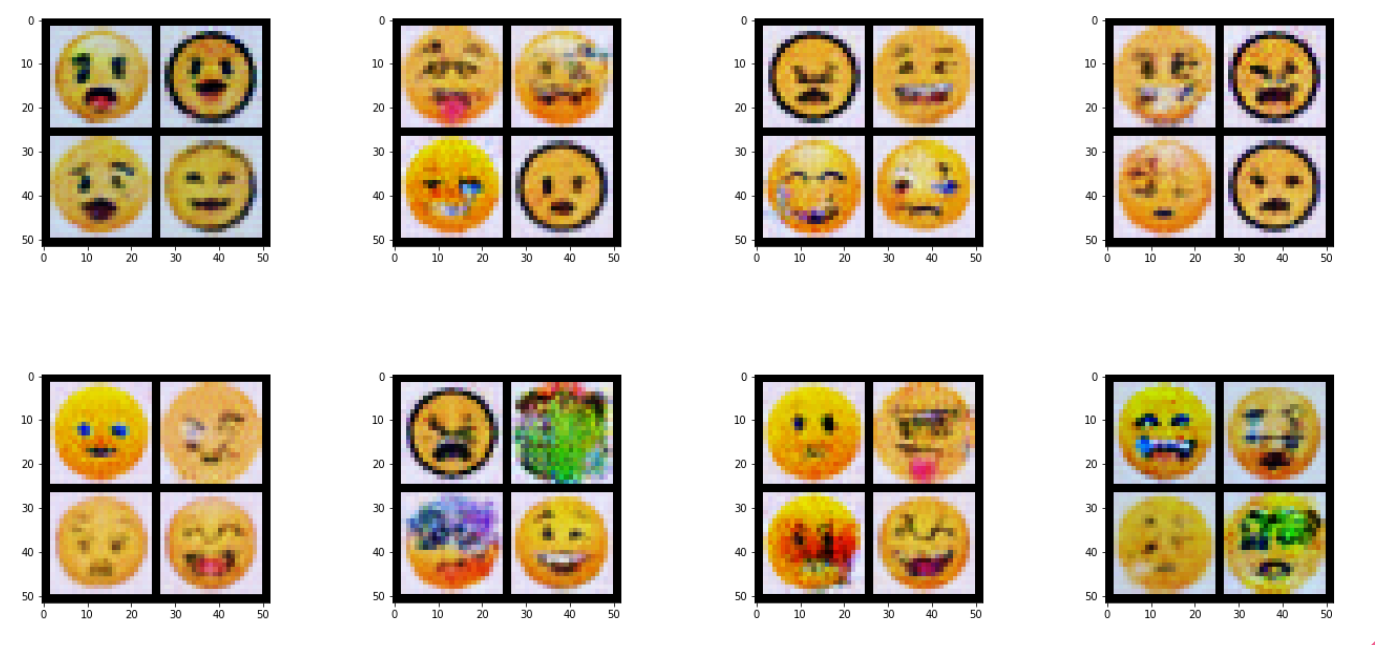